## CLIP (ViT-B/32) + Projection MLP + mT5-Small Decoder Pipeline

Bu bölüm: 
- CLIP ViT-L/14 image encoder (tamamen freeze, edit: unfreeze)
- Görsel embedding -> K adet prefix token üreten MLP (öğrenilir)
- mT5-small (sadece decoder veya istersen tamamı) caption/çeviri üretimi
- Projection MLP ve mT5 decoder parametreleri eğitilecek.

Strateji (prefix approach):
1. Image -> CLIP encode_image -> (B,512)
2. MLP: 512 -> (K * d_model) reshape -> (B,K,512) -> LayerNorm
3. mT5 encoder'a inputs_embeds olarak bu prefix (opsiyonel ek tekst prompt tokenleri ile concat)
4. Decoder hedef yazıyı üretir (teacher forcing, cross-entropy)

Seçilebilir dondurma opsiyonları:
- freeze_clip = True (zorunlu senaryon)
- freeze_t5_encoder = True bırakıp sadece decoder + projection eğitilebilir

Aşağıdaki kod Flickr8k JSON (tasviret8k_captions.json) içinden (örnek) tek caption seçip dataset oluşturma iskeleti içerir.


In [ ]:
# Rerun this cell at each session start

# Uninstall conflicting packages (Kaggle specific)
!pip uninstall -y bigframes cesium gcsfs

# Performance metrics
!pip install -r /kaggle/input/requirements/requirements.txt

# To use nltk
import nltk; nltk.download('punkt'); nltk.download('wordnet'); nltk.download('omw-1.4')

# Download mT5-small ViT-B/32
import clip, torch
from transformers import MT5ForConditionalGeneration, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/mt5-small"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
mt5 = MT5ForConditionalGeneration.from_pretrained(model_name).to(device)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

print("Setup Done!")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rjj6x6wa
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rjj6x6wa
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-install-a15lgzgm/pycocoevalcap_74561caa00e74b2fb48026a31d899228
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-install-a15lgzgm/pycocoevalcap_74561caa00e74b2fb48026a31d899228
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2025-09-11 11:22:12.759152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757589732.782603     332 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757589732.789655     332 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The tokenizer class you load from this checkpoint is not the same type as the cla

Setup Done!


In [2]:
# Unified configuration (wandb init moved to next cell)
from kaggle_secrets import UserSecretsClient
import os

PROJECT_NAME = "bites-tr-image-captioning"
RUN_NAME = "clip_mt5_prefix_run"

ENABLE_WANDB = True  # Set False to skip W&B entirely

WANDB_API_KEY = UserSecretsClient().get_secret("WANDB_API_KEY")

base_config = {
    "model": "google/mt5-small",
    "clip_encoder": "ViT-B/32",  # backbone
    "prefix_tokens": 32,          # stronger conditioning
    "batch_size": 16,              # reduced to mitigate OOM
    "grad_accum_steps": 2,        # accumulate to simulate larger effective batch
    "enable_t5_gradient_checkpointing": True,  # reduce memory
    "lr": 1e-4,
    "epochs": 25,                  # allow a bit longer now that we fine-tune CLIP
    "dataset_limit": None,
    # --- CLIP fine-tuning controls ---
    "freeze_clip": False,          # set False to allow full CLIP fine-tuning
    "unfreeze_clip_last_n": 0,     # if >0 unfreezes only last N vision blocks
    "clip_lr_scale": 0.05,         # scaled LR for ALL CLIP params (lower than main)
    "use_clip_patch_tokens": True, # richer conditioning (patch tokens path) (set False to save memory)
    # --- T5 freezing ---
    "freeze_t5_encoder": False,    # unfreeze encoder so it can adapt
    "freeze_t5_decoder": False,
    # --- Optimization ---
    "seed": 42,
    "weight_decay": 0.01,
    "grad_clip": 1.0,
    "warmup_steps": 500,           # linear warmup steps before cosine decay
    # --- Inference defaults ---
    "num_beams_infer": 4,
    "max_new_tokens_infer": 32,
    "src_max_len": 64,
    "tgt_max_len": 64,
    # --- Early stopping (BLEU-based) ---
    "bleu_patience": 5,
    "bleu_min_delta": 0.0,
    "use_amp": True,
    # Optional extras:
    "use_bf16": True,
    "enable_tf32": True,
    "finite_loss_skip": True,
    "save_every": 0
}

# Global flags/handles populated after (optional) wandb init cell
use_wandb = False
cfg = None

# Always create a local cfg object here; W&B init (next cell) can sync/override
class _Cfg: ...
cfg = _Cfg()
for k, v in base_config.items():
    setattr(cfg, k, v)
print("[INFO] Local config object created.")
if ENABLE_WANDB:
    print("[INFO] Run the next 'W&B Init' cell to enable Weights & Biases tracking.")
else:
    print("[INFO] W&B disabled (ENABLE_WANDB=False). Using local config only.")

import random, numpy as np, torch
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(cfg.seed)

# --- Enforce CUDA-only environment ---
assert torch.cuda.is_available(), "CUDA GPU is required but not detected. Please run in a CUDA-enabled environment."
device = torch.device('cuda')
print(f"[DEVICE] Using CUDA device: {torch.cuda.get_device_name(device)}")

# Performance toggles
if getattr(cfg, 'enable_tf32', False):
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        print("[DEVICE] TF32 enabled.")
    except Exception as _e:
        print("[WARN] Could not enable TF32:", _e)

if getattr(cfg, 'use_bf16', False):
    bf16_ok = torch.cuda.is_bf16_supported()
    print(f"[DEVICE] bfloat16 support: {bf16_ok}")

print("Active config (local):")
for k, v in base_config.items():
    print(f"  {k}: {getattr(cfg, k)}")

[INFO] Local config object created.
[INFO] Run the next 'W&B Init' cell to enable Weights & Biases tracking.
[DEVICE] Using CUDA device: Tesla P100-PCIE-16GB
[DEVICE] TF32 enabled.
[DEVICE] bfloat16 support: True
Active config (local):
  model: google/mt5-small
  clip_encoder: ViT-B/32
  prefix_tokens: 32
  batch_size: 16
  grad_accum_steps: 2
  enable_t5_gradient_checkpointing: True
  lr: 0.0001
  epochs: 25
  dataset_limit: None
  freeze_clip: False
  unfreeze_clip_last_n: 0
  clip_lr_scale: 0.05
  use_clip_patch_tokens: True
  freeze_t5_encoder: False
  freeze_t5_decoder: False
  seed: 42
  weight_decay: 0.01
  grad_clip: 1.0
  warmup_steps: 500
  num_beams_infer: 4
  max_new_tokens_infer: 32
  src_max_len: 64
  tgt_max_len: 64
  bleu_patience: 5
  bleu_min_delta: 0.0
  use_amp: True
  use_bf16: True
  enable_tf32: True
  finite_loss_skip: True
  save_every: 0


In [ ]:
# Model, dataset and pipeline definitions (data + model init only)
import torch, os, json
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import clip
from transformers import MT5ForConditionalGeneration, AutoTokenizer

# (CUDA enforcement handled in config cell; assume cuda device later)

class ProjectionMLP(nn.Module):
    def __init__(self, in_dim, out_dim, prefix_tokens=8, hidden=1024, dropout=0.1):
        super().__init__()
        self.prefix_tokens = prefix_tokens
        self.fc1 = nn.Linear(in_dim, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, out_dim * prefix_tokens)
        self.ln = nn.LayerNorm(out_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.fc2(x)
        x = x.view(x.size(0), self.prefix_tokens, -1)
        x = self.ln(x)
        return self.dropout(x)

class CLIPmT5Pipeline(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        # Use AutoTokenizer so class matches checkpoint declaration (T5Tokenizer vs MT5Tokenizer)
        self.tokenizer = AutoTokenizer.from_pretrained(cfg.model, use_fast=False)
        self.model = MT5ForConditionalGeneration.from_pretrained(cfg.model)
        if getattr(cfg, 'enable_t5_gradient_checkpointing', False):
            try:
                self.model.gradient_checkpointing_enable()
                print('[MEM] Enabled T5 gradient checkpointing.')
            except Exception as e:
                print('[WARN] Could not enable gradient checkpointing:', e)
        self.clip, _ = clip.load(cfg.clip_encoder, device="cpu")
        # CLIP freezing / unfreezing strategy
        if cfg.unfreeze_clip_last_n and cfg.unfreeze_clip_last_n > 0:
            # Freeze everything first
            for p in self.clip.parameters():
                p.requires_grad = False
            blocks = list(self.clip.visual.transformer.resblocks)
            for block in blocks[-cfg.unfreeze_clip_last_n:]:
                for p in block.parameters():
                    p.requires_grad = True
        else:
            # Respect freeze_clip flag (False means fully trainable)
            for p in self.clip.parameters():
                p.requires_grad = not cfg.freeze_clip
        # T5 freeze toggles
        if cfg.freeze_t5_encoder:
            for p in self.model.encoder.parameters():
                p.requires_grad = False
        if cfg.freeze_t5_decoder:
            for p in self.model.decoder.parameters():
                p.requires_grad = False
        self.prefix_tokens = cfg.prefix_tokens
        # Determine embedding dim dynamically (CLIP projection output)
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            embed_dim = self.clip.visual.output_dim if hasattr(self.clip.visual, 'output_dim') else self.clip.encode_image(dummy).shape[-1]
        self.proj = ProjectionMLP(in_dim=embed_dim, out_dim=self.model.config.d_model, prefix_tokens=cfg.prefix_tokens)
        self._cached_sentinel_ids = None  # lazy cache

    def _encode_image_single(self, images: torch.Tensor):
        pooled = self.clip.encode_image(images)
        return pooled

    def _encode_image_patch_tokens(self, images: torch.Tensor):
        visual = self.clip.visual
        x = visual.conv1(images)
        x = x.reshape(x.shape[0], x.shape[1], -1)
        x = x.permute(0, 2, 1)
        cls_tokens = visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + visual.positional_embedding.to(x.dtype)
        x = visual.ln_pre(x)
        x = x.permute(1, 0, 2)
        for block in visual.transformer.resblocks:
            x = block(x)
        x = x.permute(1, 0, 2)
        patches = x[:, 1:, :]
        pooled = patches.mean(dim=1)
        if hasattr(visual, 'ln_post'):
            pooled = visual.ln_post(pooled)
        if hasattr(visual, 'proj') and visual.proj is not None:
            pooled = pooled @ visual.proj
        return pooled

    def forward(self, images, src_texts, tgt_texts):
        device = next(self.parameters()).device
        images = images.to(device)
        clip_emb = self._encode_image_patch_tokens(images) if self.cfg.use_clip_patch_tokens else self._encode_image_single(images)
        prefix_emb = self.proj(clip_emb)
        tok_src = self.tokenizer(list(src_texts), return_tensors='pt', padding=True, truncation=True, max_length=self.cfg.src_max_len).to(device)
        tok_tgt = self.tokenizer(list(tgt_texts), return_tensors='pt', padding=True, truncation=True, max_length=self.cfg.tgt_max_len).to(device)

        # Mask PADs in labels so they don't contribute to loss
        labels = tok_tgt.input_ids.clone()
        pad_id = self.tokenizer.pad_token_id
        if pad_id is not None:
            labels[labels == pad_id] = -100

        text_emb = self.model.encoder.embed_tokens(tok_src.input_ids)
        full_emb = torch.cat([prefix_emb, text_emb], dim=1)
        full_attn = torch.cat([
            torch.ones(prefix_emb.size(0), self.prefix_tokens, dtype=tok_src.attention_mask.dtype, device=device),
            tok_src.attention_mask
        ], dim=1)
        model_out = self.model(inputs_embeds=full_emb, attention_mask=full_attn, labels=labels)
        try:
            setattr(model_out, 'labels', labels)
        except Exception:
            pass
        return model_out

    @torch.inference_mode()
    def generate(self, image_paths=None, images=None, num_beams=None, max_new_tokens=None, prompt="Bu görüntüyü açıkla: ", ban_sentinels=True, **gen_kwargs):
        device = next(self.parameters()).device
        num_beams = num_beams or self.cfg.num_beams_infer
        max_new_tokens = max_new_tokens or self.cfg.max_new_tokens_infer
        if images is None:
            assert image_paths is not None, "Provide image_paths or images tensor"
            preprocess = clip.load(self.cfg.clip_encoder, device='cpu')[1]
            pil_images = [Image.open(p).convert('RGB') for p in image_paths]
            images = torch.stack([preprocess(im) for im in pil_images])
        images = images.to(device)
        prefix_tokens = self._prepare_prefix(images)
        tok = self.tokenizer([prompt]*images.size(0), return_tensors='pt', padding=True, truncation=True, max_length=self.cfg.src_max_len).to(device)
        text_emb = self.model.encoder.embed_tokens(tok.input_ids)
        full_emb = torch.cat([prefix_tokens, text_emb], dim=1)
        full_attn = torch.cat([
            torch.ones(images.size(0), self.prefix_tokens, device=device, dtype=tok.attention_mask.dtype),
            tok.attention_mask
        ], dim=1)
        bad_words_ids = self._get_sentinel_bad_words() if ban_sentinels else None
        gen_ids = self.model.generate(
            inputs_embeds=full_emb,
            attention_mask=full_attn,
            num_beams=num_beams,
            max_new_tokens=max_new_tokens,
            bad_words_ids=bad_words_ids,
            **gen_kwargs
        )
        captions = [self.tokenizer.decode(g, skip_special_tokens=True).strip() for g in gen_ids]
        return [c if c else "<EMPTY>" for c in captions]

    def _prepare_prefix(self, images: torch.Tensor):
        images = images.to(next(self.parameters()).device)
        emb = self._encode_image_patch_tokens(images) if self.cfg.use_clip_patch_tokens else self._encode_image_single(images)
        return self.proj(emb)

    def _get_sentinel_bad_words(self, n=50):
        if self._cached_sentinel_ids is None:
            ids = [self.tokenizer(f'<extra_id_{i}>').input_ids[0] for i in range(n)]
            self._cached_sentinel_ids = [[i] for i in ids]
        return self._cached_sentinel_ids

class Flickr8kCaptions(Dataset):
    def __init__(self, json_path, images_root, split=None, limit=None, clip_preprocess=None):
        self.images_root = images_root
        raw = json.load(open(json_path))
        rows = raw['images'] if isinstance(raw, dict) and 'images' in raw else raw
        self.samples = []
        for row in rows:
            if not isinstance(row, dict): continue
            if split and row.get('split') != split: continue
            img = row.get('filename') or row.get('image') or row.get('img')
            sentences = row.get('sentences')
            if not img or not sentences: continue
            for s in sentences:
                if isinstance(s, dict) and 'raw' in s:
                    self.samples.append((img, s['raw']))
        if limit: self.samples = self.samples[:limit]
        self.transform = clip_preprocess or clip.load(cfg.clip_encoder, device='cpu')[1]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_name, cap = self.samples[idx]
        path = os.path.join(self.images_root, img_name)
        image = Image.open(path).convert('RGB')
        # Align training source prompt with inference default
        return self.transform(image), "Bu görüntüyü açıkla: ", cap

In [4]:
# (Optional) Weights & Biases initialization
# Run this AFTER the config cell if you want online logging,
# otherwise skip to keep everything offline.
if 'ENABLE_WANDB' in globals() and ENABLE_WANDB:
    try:
        import wandb
        wandb.login(key=WANDB_API_KEY)
        run = wandb.init(project=PROJECT_NAME, name=RUN_NAME, config=base_config, reinit=True)
        cfg = wandb.config  # sync cfg to wandb
        # Explicitly log config dict to the run (config, summary, and a one-time log)
        try:
            cfg_dict = dict(base_config)
        except Exception:
            cfg_dict = {k: getattr(cfg, k) for k in base_config.keys() if hasattr(cfg, k)}
        wandb.config.update(cfg_dict, allow_val_change=True)
        # Store a namespaced copy in summary for quick viewing
        wandb.summary.update({f"cfg/{k}": v for k, v in cfg_dict.items()})
        # Also log once at step 0 for time-series traceability
        wandb.log({"cfg": cfg_dict}, step=0)
        use_wandb = True
        print('[wandb] run initialized and config logged.')
    except Exception as e:
        use_wandb = False
        print('[wandb] disabled (init failed):', e)
else:
    print('[wandb] Skipped (ENABLE_WANDB is False).')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abdulkadirparlak (abdulkadirparlak-hacettepe-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[wandb] run initialized and config logged.


In [5]:
# Data Loading
json_path = '/kaggle/input/tasviret/flickr8k/tasviret8k_captions.json'
images_root = '/kaggle/input/tasviret/flickr8k/Images'
train_dataset = Flickr8kCaptions(json_path, images_root, split='train', limit=cfg.dataset_limit)
val_dataset   = Flickr8kCaptions(json_path, images_root, split='val',   limit=1000)
test_dataset  = Flickr8kCaptions(json_path, images_root, split='test',  limit=None)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=cfg.batch_size, shuffle=False) if len(val_dataset)>0 else None
test_loader  = DataLoader(test_dataset,  batch_size=cfg.batch_size, shuffle=False) if len(test_dataset)>0 else None

model_mm = CLIPmT5Pipeline(cfg)
print(f"Train samples: {len(train_dataset)}  Val: {len(val_dataset)}  Test: {len(test_dataset)}")
print("Clip ViT-B/32 params:", sum(p.numel() for p in model_mm.clip.parameters() if p.requires_grad))
print("Projection params:", sum(p.numel() for p in model_mm.proj.parameters() if p.requires_grad))
print("mt5-small params:", sum(p.numel() for p in model_mm.model.parameters() if p.requires_grad))
print("Total trainable params:", sum(p.numel() for p in model_mm.parameters() if p.requires_grad))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


[MEM] Enabled T5 gradient checkpointing.
Train samples: 12028  Val: 1000  Test: 2003
Clip ViT-B/32 params: 151277313
Projection params: 17319936
mt5-small params: 300176768
Total trainable params: 468774017


In [ ]:
# Training cell (training + validation + BLEU-1-based model selection w/ patience)
import math, time, torch, warnings, os
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch import nn

assert torch.cuda.is_available(), "CUDA GPU required."
device = torch.device('cuda')
model_mm.to(device)

grad_accum_steps = getattr(cfg, 'grad_accum_steps', 1)

amp_dtype = None
if getattr(cfg, 'use_amp', True):
    if getattr(cfg, 'use_bf16', False) and torch.cuda.is_bf16_supported():
        amp_dtype = torch.bfloat16
        print("[AMP] Using bfloat16 mixed precision")
    else:
        amp_dtype = torch.float16
        print("[AMP] Using float16 mixed precision")
else:
    print("[AMP] Disabled; using full float32")

main_params, clip_params = [], []
for name, p in model_mm.named_parameters():
    if not p.requires_grad: continue
    (clip_params if name.startswith('clip.') else main_params).append(p)
param_groups = []
if main_params: param_groups.append({"params": main_params, "lr": cfg.lr})
if clip_params:
    scaled_lr = cfg.lr * getattr(cfg, 'clip_lr_scale', 0.05)
    param_groups.append({"params": clip_params, "lr": scaled_lr})
    print(f"[INFO] CLIP fine-tune params: {len(clip_params)} with lr={scaled_lr:.2e}")
optimizer = AdamW(param_groups, weight_decay=cfg.weight_decay)

steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * cfg.epochs // grad_accum_steps

def lr_lambda(step):
    if cfg.warmup_steps > 0 and step < cfg.warmup_steps:
        return float(step) / float(max(1, cfg.warmup_steps))
    progress = (step - cfg.warmup_steps) / float(max(1, total_steps - cfg.warmup_steps))
    progress = min(max(progress, 0.0), 1.0)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
scaler = torch.amp.GradScaler('cuda', enabled=amp_dtype is not None)
CKPT_DIR = 'checkpoints'; os.makedirs(CKPT_DIR, exist_ok=True)

# BLEU-1-based selection with early stopping AFTER first N epochs
best_bleu = float('-inf')
bleu_stall_epochs = 0
bleu_patience = getattr(cfg, 'bleu_patience', 5)
bleu_min_delta = getattr(cfg, 'bleu_min_delta', 0.0)
min_epochs_before_early_stop = 10  # early-stop starts after finishing this many epochs
BEST_CKPT_NAME = 'best_bleu.pt'

from collections import defaultdict

def compute_val_caption_metrics(model, val_dataset, images_root, batch_size=16, amp_dtype=None):
    if val_dataset is None or len(val_dataset) == 0: return {}
    refs_map = defaultdict(list)
    for fname, cap in val_dataset.samples:
        c = cap.strip()
        if c: refs_map[fname].append(c)
    if not refs_map: return {}
    image_files = list(refs_map.keys())
    image_paths = [os.path.join(images_root, f) for f in image_files]
    hyps, refs = [], []
    def _generate(paths):
        if amp_dtype is not None:
            with torch.amp.autocast('cuda', dtype=amp_dtype):
                return model.generate(image_paths=paths, ban_sentinels=True)
        return model.generate(image_paths=paths, ban_sentinels=True)
    model.eval()
    for i in range(0, len(image_paths), batch_size):
        b = image_paths[i:i+batch_size]
        outs = _generate(b)
        for pth, pred in zip(b, outs):
            fname = os.path.basename(pth)
            hyps.append(pred if pred else "<EMPTY>")
            refs.append(refs_map.get(fname, [" "]))
    gts = {i: refs[i] for i in range(len(refs))}
    res = {i: [hyps[i]] for i in range(len(hyps))}
    metrics = {}
    try:
        from pycocoevalcap.bleu.bleu import Bleu
        bleu_scores, _ = Bleu(4).compute_score(gts, res)
        metrics['bleu1'] = float(bleu_scores[0])
        metrics['bleu4'] = float(bleu_scores[3])
    except Exception as e:
        print('[WARN] BLEU failed:', e)
    return metrics

print(f"[TRAIN] Starting training with BLEU-1-based checkpointing + delayed patience (after {min_epochs_before_early_stop} epochs). GradAccum={grad_accum_steps}")

criterion = torch.nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.0)

def compute_loss_with_label_smoothing(model_out):
    logits = model_out.logits  # (B, T, V)
    labels = getattr(model_out, 'labels', None)
    if labels is None:
        raise AttributeError('Labels not found on model output; ensure forward attaches them.')
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = labels[:, 1:].contiguous()
    loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

# Track history for plotting
train_losses, val_losses, epochs_list = [], [], []

global_step = 0
stopped_early = False
for epoch in range(cfg.epochs):
    # Activate patience window after threshold and reset stall counter once
    if (epoch + 1) == min_epochs_before_early_stop:
        bleu_stall_epochs = 0
        print(f"[ES] Epoch {epoch+1}: BLEU-1 patience becomes active; stall counter reset.")

    model_mm.train()
    train_sum = 0.0
    t0 = time.time()
    optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(train_loader, start=1):
        imgs, srcs, tgts = batch
        imgs = imgs.to(device, non_blocking=True)
        if amp_dtype is not None:
            with torch.amp.autocast('cuda', dtype=amp_dtype):
                out = model_mm(imgs, srcs, tgts)
                loss = compute_loss_with_label_smoothing(out) / grad_accum_steps
            scaler.scale(loss).backward()
        else:
            out = model_mm(imgs, srcs, tgts)
            loss = compute_loss_with_label_smoothing(out) / grad_accum_steps
            loss.backward()
        if step % grad_accum_steps == 0:
            if amp_dtype is not None:
                if cfg.grad_clip and cfg.grad_clip > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model_mm.parameters(), cfg.grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                if cfg.grad_clip and cfg.grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model_mm.parameters(), cfg.grad_clip)
                optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            global_step += 1
        train_sum += (loss.item() * grad_accum_steps)
    train_epoch_loss = train_sum / max(1, len(train_loader))

    val_epoch_loss = None
    if val_loader:
        model_mm.eval(); v = 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs, srcs, tgts = batch
                imgs = imgs.to(device, non_blocking=True)
                if amp_dtype is not None:
                    with torch.amp.autocast('cuda', dtype=amp_dtype):
                        out = model_mm(imgs, srcs, tgts)
                        loss_val = compute_loss_with_label_smoothing(out)
                else:
                    out = model_mm(imgs, srcs, tgts)
                    loss_val = compute_loss_with_label_smoothing(out)
                v += loss_val.item()
        val_epoch_loss = v / max(1, len(val_loader))

    metrics = compute_val_caption_metrics(model_mm, val_dataset, images_root, batch_size=16, amp_dtype=amp_dtype)
    bleu1 = metrics.get('bleu1', float('-inf'))
    bleu4 = metrics.get('bleu4', float('nan'))

    dt = time.time() - t0
    current_lr = scheduler.get_last_lr()[0]

    # Record history for plotting
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss if val_epoch_loss is not None else float('nan'))
    epochs_list.append(epoch + 1)

    if val_epoch_loss is not None:
        print(f"Epoch {epoch+1:02d}/{cfg.epochs} train_loss={train_epoch_loss:.4f} val_loss={val_epoch_loss:.4f} BLEU1={bleu1:.3f} BLEU4={bleu4:.3f} time={dt:.1f}s lr={current_lr:.2e}")
    else:
        print(f"Epoch {epoch+1:02d}/{cfg.epochs} train_loss={train_epoch_loss:.4f} BLEU1={bleu1:.3f} BLEU4={bleu4:.3f} time={dt:.1f}s lr={current_lr:.2e}")

    if use_wandb:
        log_dict = {
            'train/epoch_loss': train_epoch_loss,
            'lr': current_lr,
            'val/bleu1': bleu1,
            'val/bleu4': bleu4,
        }
        if val_epoch_loss is not None:
            log_dict['val/epoch_loss'] = val_epoch_loss
        wandb.log(log_dict, step=epoch)

    improved_bleu = (bleu1 - best_bleu) > bleu_min_delta
    if improved_bleu:
        best_bleu = bleu1
        bleu_stall_epochs = 0
        save_payload = {
            'model': model_mm.state_dict(),
            'cfg': {k: getattr(cfg, k) for k in base_config.keys()},
            'epoch': epoch,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_bleu1': best_bleu,
            'bleu4': bleu4,
            'val_loss': val_epoch_loss,
            'train_loss': train_epoch_loss,
            'global_step': global_step,
        }
        torch.save(save_payload, os.path.join(CKPT_DIR, BEST_CKPT_NAME))
        print(f"  -> Saved {BEST_CKPT_NAME} (BLEU1={best_bleu:.4f})")
    else:
        if (epoch + 1) >= min_epochs_before_early_stop:
            bleu_stall_epochs += 1
            print(f"  -> No BLEU-1 improvement (stall epochs={bleu_stall_epochs}/{bleu_patience})")
        else:
            print("  -> No BLEU-1 improvement (patience inactive until epoch 10)")

    can_early_stop = (epoch + 1) >= min_epochs_before_early_stop
    if can_early_stop and bleu_stall_epochs >= bleu_patience:
        print(f"[Early Stop] BLEU-1 not improved for {bleu_patience} consecutive epochs after epoch {min_epochs_before_early_stop}.")
        stopped_early = True
        break

print(f"Training finished. Best BLEU-1={best_bleu:.4f} {'(early stop)' if stopped_early else ''}")

[AMP] Using bfloat16 mixed precision
[INFO] CLIP fine-tune params: 302 with lr=5.00e-06
[TRAIN] Starting training with BLEU-1-based checkpointing + delayed patience (after 10 epochs). GradAccum=2


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'testlen': 13605, 'reflen': 4731, 'guess': [13605, 13106, 12607, 12108], 'correct': [622, 1, 0, 0]}
ratio: 2.875713379834522
Epoch 01/25 train_loss=28.1972 val_loss=8.5839 BLEU1=0.046 BLEU4=0.000 time=578.8s lr=7.52e-05
  -> Saved best_bleu.pt (BLEU1=0.0457)
{'testlen': 15968, 'reflen': 4870, 'guess': [15968, 15469, 14970, 14471], 'correct': [629, 1, 0, 0]}
ratio: 3.278850102668731
Epoch 02/25 train_loss=6.6937 val_loss=4.9515 BLEU1=0.039 BLEU4=0.000 time=536.4s lr=9.98e-05
  -> No BLEU-1 improvement (patience inactive until epoch 10)
{'testlen': 499, 'reflen': 3293, 'guess': [499, 0, 0, 0], 'correct': [0, 0, 0, 0]}
ratio: 0.15153355602789204
Epoch 03/25 train_loss=5.5296 val_loss=5.1608 BLEU1=0.000 BLEU4=0.000 time=535.2s lr=9.88e-05
  -> No BLEU-1 improvement (patience inactive until epoch 10)
{'testlen': 1497, 'reflen': 3293, 'guess': [1497, 998, 499, 0], 'correct': [0, 0, 0, 0]}
ratio: 0.4546006680836761
Epoch 04/25 train_loss=4.9725 val_loss=4.5072 BLEU1=0.000 BLEU4=0.000 time=53

In [7]:
# === Model Export / Import Utilities ===
import os, json, torch, math
from datetime import datetime
from typing import Optional, Dict, Any, Tuple

# ------------------------------
# Export
# ------------------------------

def export_model(
    save_dir: str,
    model: torch.nn.Module,
    cfg_obj,
    optimizer: Optional[torch.optim.Optimizer] = None,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    epoch: Optional[int] = None,
    global_step: Optional[int] = None,
    best_val: Optional[float] = None,
    tag: str = "latest",
    use_safetensors: bool = False,
    # --- BLEU-aware exporting additions ---
    best_bleu: Optional[float] = None,
    bleu_scores: Optional[Dict[str, float]] = None,  # e.g., {'bleu1': ..., 'bleu4': ...}
    save_best_on_bleu: bool = False,
    bleu_min_delta: float = 0.0,
    best_registry_filename: str = "best_bleu.json",
) -> str:
    """Export model checkpoint + (optional) optimizer/scheduler.

    Saves:
      - config.json (raw cfg values)
      - tokenizer/ (HF tokenizer)
      - clip_mt5_prefix_<tag>.pt (bundle) OR .safetensors (+ meta files)

    Bundle (.pt) contains:
      model_state, cfg, epoch, global_step, tag, export_time,
      optimizer_state?, scheduler_state?, best_val?, best_bleu?, bleu_scores?, hyperparams.

    If save_best_on_bleu=True, the function will only save when `best_bleu`
    strictly improves over the previous best by > bleu_min_delta. Best state is
    tracked in <save_dir>/<best_registry_filename>.

    hyperparams dict added so retraining can auto‑rebuild optimizer/scheduler:
      { lr, clip_lr_scale, weight_decay, warmup_steps, grad_clip, use_amp, use_bf16 }
    """
    os.makedirs(save_dir, exist_ok=True)

    # Collect base config keys if available
    if 'base_config' in globals():
        cfg_dict = {k: getattr(cfg_obj, k) for k in base_config.keys() if hasattr(cfg_obj, k)}
    else:
        cfg_dict = {k: v for k, v in vars(cfg_obj).items() if not k.startswith('_')}

    # Persist config separately (human readable)
    with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(cfg_dict, f, ensure_ascii=False, indent=2)

    # Save tokenizer (best effort)
    try:
        model.tokenizer.save_pretrained(os.path.join(save_dir, 'tokenizer'))
    except Exception as e:
        print(f"[WARN] Tokenizer save failed: {e}")

    # Load current best BLEU from registry (if gating by BLEU)
    registry_path = os.path.join(save_dir, best_registry_filename)
    prev_best_bleu = None
    prev_best_path = None
    if os.path.isfile(registry_path):
        try:
            with open(registry_path, 'r') as rf:
                reg = json.load(rf)
            prev_best_bleu = reg.get('best_bleu')
            prev_best_path = reg.get('path')
        except Exception:
            pass

    if save_best_on_bleu:
        if best_bleu is None:
            print("[EXPORT] save_best_on_bleu=True but best_bleu=None; skip saving.")
            return prev_best_path or ""
        improved = (prev_best_bleu is None) or ((best_bleu - float(prev_best_bleu)) > float(bleu_min_delta))
        if not improved:
            print(f"[EXPORT] BLEU not improved (cur={best_bleu}, best={prev_best_bleu}); skip.")
            return prev_best_path or ""
        # If we're saving by BLEU and tag isn't explicit, use 'best'
        if tag in (None, "", "latest"):
            tag = "best"

    checkpoint_name = f"clip_mt5_prefix_{tag}"

    hyperparams = {
        'lr': cfg_dict.get('lr'),
        'clip_lr_scale': cfg_dict.get('clip_lr_scale'),
        'weight_decay': cfg_dict.get('weight_decay'),
        'warmup_steps': cfg_dict.get('warmup_steps'),
        'grad_clip': cfg_dict.get('grad_clip'),
        'use_amp': cfg_dict.get('use_amp'),
        'use_bf16': cfg_dict.get('use_bf16'),
        'batch_size': cfg_dict.get('batch_size'),
    }

    # Common metadata for both formats
    meta = {
        'cfg': cfg_dict,
        'epoch': epoch,
        'global_step': global_step,
        'export_time': datetime.utcnow().isoformat() + 'Z',
        'tag': tag,
        'best_val': best_val,
        'best_bleu': best_bleu,
        'bleu_scores': bleu_scores,
        'has_optimizer': optimizer is not None,
        'has_scheduler': scheduler is not None,
        'hyperparams': hyperparams,
    }

    saved_path = ""

    if use_safetensors:
        try:
            from safetensors.torch import save_file
            weights = model.state_dict()
            save_path = os.path.join(save_dir, checkpoint_name + '.safetensors')
            save_file(weights, save_path)
            if optimizer:
                torch.save(optimizer.state_dict(), os.path.join(save_dir, checkpoint_name + '.optimizer.pt'))
            if scheduler:
                torch.save(scheduler.state_dict(), os.path.join(save_dir, checkpoint_name + '.scheduler.pt'))
            # Write meta.json (always reflects last export)
            with open(os.path.join(save_dir, 'meta.json'), 'w') as f:
                json.dump(meta, f, indent=2)
            print(f"[EXPORT] Weights -> {checkpoint_name}.safetensors (meta.json written)")
            saved_path = save_path
        except ImportError:
            print('[WARN] safetensors not installed; falling back to .pt')
            use_safetensors = False
        except Exception as e:
            print(f"[ERROR] safetensors save failed: {e}")
            return prev_best_path or ""

    if not use_safetensors:
        # Standard .pt route
        bundle = {
            'model_state': model.state_dict(),
            'cfg': cfg_dict,
            'epoch': epoch,
            'global_step': global_step,
            'export_time': datetime.utcnow().isoformat() + 'Z',
            'tag': tag,
            'best_val': best_val,
            'best_bleu': best_bleu,
            'bleu_scores': bleu_scores,
            'hyperparams': hyperparams,
        }
        if optimizer:
            bundle['optimizer_state'] = optimizer.state_dict()
        if scheduler:
            bundle['scheduler_state'] = scheduler.state_dict()
        out_path = os.path.join(save_dir, checkpoint_name + '.pt')
        torch.save(bundle, out_path)
        # Also emit meta.json for parity with safetensors
        with open(os.path.join(save_dir, 'meta.json'), 'w') as f:
            json.dump(meta, f, indent=2)
        print(f"[EXPORT] Saved checkpoint: {out_path}")
        saved_path = out_path

    # Update best BLEU registry if we saved under BLEU gating
    if save_best_on_bleu and best_bleu is not None and saved_path:
        try:
            reg = {
                'best_bleu': float(best_bleu),
                'bleu_scores': bleu_scores,
                'path': saved_path,
                'epoch': epoch,
                'global_step': global_step,
                'updated_at': datetime.utcnow().isoformat() + 'Z',
            }
            with open(registry_path, 'w') as wf:
                json.dump(reg, wf, indent=2)
            print(f"[EXPORT] Updated registry {best_registry_filename}: best_bleu={best_bleu:.4f}")
        except Exception as e:
            print(f"[WARN] Could not update best BLEU registry: {e}")

    return saved_path

# Convenience wrapper: export only if BLEU improved, saved as 'best'
def export_best_bleu(
    save_dir: str,
    model: torch.nn.Module,
    cfg_obj,
    *,
    best_bleu: float,
    bleu_scores: Optional[Dict[str, float]] = None,
    optimizer: Optional[torch.optim.Optimizer] = None,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    epoch: Optional[int] = None,
    global_step: Optional[int] = None,
    use_safetensors: bool = False,
    bleu_min_delta: float = 0.0,
    best_registry_filename: str = "best_bleu.json",
) -> str:
    return export_model(
        save_dir=save_dir,
        model=model,
        cfg_obj=cfg_obj,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epoch,
        global_step=global_step,
        best_val=None,
        tag="best",
        use_safetensors=use_safetensors,
        best_bleu=best_bleu,
        bleu_scores=bleu_scores,
        save_best_on_bleu=True,
        bleu_min_delta=bleu_min_delta,
        best_registry_filename=best_registry_filename,
    )

# ------------------------------
# Helper: build optimizer (main + clip groups)
# ------------------------------

def build_optimizer_from_hparams(model: torch.nn.Module, h: Dict[str, Any]):
    lr = h.get('lr', 1e-4)
    clip_lr_scale = h.get('clip_lr_scale', 0.05) or 0.05
    weight_decay = h.get('weight_decay', 0.0)
    main_params, clip_params = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        (clip_params if n.startswith('clip.') else main_params).append(p)
    param_groups = []
    if main_params:
        param_groups.append({'params': main_params, 'lr': lr})
    if clip_params:
        param_groups.append({'params': clip_params, 'lr': lr * clip_lr_scale})
    if clip_params:
        print(f"[OPT] CLIP params: {len(clip_params)} lr={lr * clip_lr_scale:.2e}")
    return torch.optim.AdamW(param_groups, weight_decay=weight_decay)

# ------------------------------
# Helper: build cosine scheduler with warmup (same as training)
# ------------------------------

def build_scheduler_from_hparams(optimizer, h: Dict[str, Any], steps_per_epoch: int, total_epochs: int):
    warmup_steps = h.get('warmup_steps', 0) or 0
    total_steps = steps_per_epoch * total_epochs
    def lr_lambda(step):
        if warmup_steps > 0 and step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        progress = (step - warmup_steps) / float(max(1, total_steps - warmup_steps)) if total_steps > warmup_steps else 1.0
        progress = min(max(progress, 0.0), 1.0)
        return 0.5 * (1 + math.cos(math.pi * progress))
    from torch.optim.lr_scheduler import LambdaLR
    return LambdaLR(optimizer, lr_lambda=lr_lambda)

# ------------------------------
# Import for finetune (unchanged except now returns hyperparams)
# ------------------------------

def load_model_for_finetune(
    load_dir: str,
    device: torch.device,
    checkpoint_tag: str = 'latest',
    resume_optimizer: bool = True,
    build_optimizer_fn=None,
    build_scheduler_fn=None,
    override_cfg: Optional[Dict[str, Any]] = None,
    prefer_safetensors: bool = True
):
    # Load config
    with open(os.path.join(load_dir, 'config.json'), 'r', encoding='utf-8') as f:
        cfg_json = json.load(f)
    if override_cfg:
        cfg_json.update(override_cfg)

    class _Cfg: ...
    cfg_obj = _Cfg()
    for k, v in cfg_json.items():
        setattr(cfg_obj, k, v)

    model = CLIPmT5Pipeline(cfg_obj).to(device)

    ckpt_base = f"clip_mt5_prefix_{checkpoint_tag}"
    safepath = os.path.join(load_dir, ckpt_base + '.safetensors')
    ptpath = os.path.join(load_dir, ckpt_base + '.pt')

    optimizer_state = scheduler_state = None
    epoch = global_step = None
    hyperparams = None
    used_safetensors = False

    if prefer_safetensors and os.path.isfile(safepath):
        try:
            from safetensors.torch import load_file
            weights = load_file(safepath, device=device)
            model.load_state_dict(weights, strict=True)
            used_safetensors = True
            meta_path = os.path.join(load_dir, 'meta.json')
            meta = {}
            if os.path.isfile(meta_path):
                with open(meta_path, 'r') as f:
                    meta = json.load(f)
            epoch = meta.get('epoch'); global_step = meta.get('global_step')
            hyperparams = meta.get('hyperparams')
            # Optional: read BLEU metadata (not returned)
            _best_bleu = meta.get('best_bleu'); _bleu_scores = meta.get('bleu_scores')
            if resume_optimizer and meta.get('has_optimizer'):
                opt_file = os.path.join(load_dir, ckpt_base + '.optimizer.pt')
                if os.path.isfile(opt_file):
                    optimizer_state = torch.load(opt_file, map_location='cpu')
            if resume_optimizer and meta.get('has_scheduler'):
                sch_file = os.path.join(load_dir, ckpt_base + '.scheduler.pt')
                if os.path.isfile(sch_file):
                    scheduler_state = torch.load(sch_file, map_location='cpu')
        except Exception as e:
            print(f"[WARN] safetensors load failed ({e}); falling back to .pt")
            used_safetensors = False

    if not used_safetensors:
        if not os.path.isfile(ptpath):
            raise FileNotFoundError(f"No checkpoint found at {ptpath}")
        bundle = torch.load(ptpath, map_location=device)
        model.load_state_dict(bundle['model_state'], strict=True)
        epoch = bundle.get('epoch'); global_step = bundle.get('global_step')
        hyperparams = bundle.get('hyperparams')
        # Optional BLEU metadata
        _best_bleu = bundle.get('best_bleu'); _bleu_scores = bundle.get('bleu_scores')
        if resume_optimizer:
            optimizer_state = bundle.get('optimizer_state')
            scheduler_state = bundle.get('scheduler_state')

    print(f"[IMPORT] Model loaded (epoch={epoch}, global_step={global_step})")
    return model, cfg_obj, hyperparams, optimizer_state, scheduler_state, epoch, global_step

# ------------------------------
# Simple one-shot retrain loader
# ------------------------------

def load_model_for_retrain(
    checkpoint_path: str,
    device: torch.device,
    new_lr: Optional[float] = None,
    new_clip_lr_scale: Optional[float] = None,
    reset_optimizer: bool = True,
    freeze_clip: Optional[bool] = None,
    override_cfg: Optional[Dict[str, Any]] = None,
):
    """Load a .pt bundle and prepare model + (fresh) optimizer hyperparams for retraining.

    Returns (model, cfg_obj, optimizer_hparams, epoch_loaded, global_step_loaded)
    Caller should then: optimizer = build_optimizer_from_hparams(model, optimizer_hparams)
    and build a new scheduler with build_scheduler_from_hparams once steps_per_epoch known.
    """
    assert os.path.isfile(checkpoint_path), f"Checkpoint not found: {checkpoint_path}"
    bundle = torch.load(checkpoint_path, map_location=device)
    if 'model_state' not in bundle:
        raise ValueError('Not an export_model bundle (.pt)')
    cfg_json = dict(bundle['cfg'])
    if override_cfg:
        cfg_json.update(override_cfg)

    class _Cfg: ...
    cfg_obj = _Cfg()
    for k, v in cfg_json.items():
        setattr(cfg_obj, k, v)
    if freeze_clip is not None:
        cfg_obj.freeze_clip = freeze_clip

    model = CLIPmT5Pipeline(cfg_obj).to(device)
    model.load_state_dict(bundle['model_state'], strict=True)

    base_h = bundle.get('hyperparams', {})
    # Override learning rates if requested
    if new_lr is not None:
        base_h['lr'] = new_lr
    if new_clip_lr_scale is not None:
        base_h['clip_lr_scale'] = new_clip_lr_scale

    # If freezing clip newly, we still keep clip_lr_scale but it won't matter
    epoch_loaded = bundle.get('epoch')
    global_step_loaded = bundle.get('global_step')
    # Optional BLEU metadata
    _best_bleu = bundle.get('best_bleu'); _bleu_scores = bundle.get('bleu_scores')
    print(f"[RETRAIN] Loaded weights (epoch={epoch_loaded}). Preparing fresh optimizer hyperparams.")
    return model, cfg_obj, base_h, epoch_loaded, global_step_loaded

print('[READY] Enhanced export/import + retrain helpers available (BLEU-aware best checkpointing).')

[READY] Enhanced export/import + retrain helpers available (BLEU-aware best checkpointing).


In [ ]:
# Plot training vs validation loss
import matplotlib.pyplot as plt

if 'epochs_list' in globals() and len(epochs_list) == len(train_losses) == len(val_losses) and len(epochs_list) > 0:
    plt.figure(figsize=(7,4))
    plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs_list, val_losses, label='Val Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No loss history found. Run the training cell first to populate train_losses/val_losses/epochs_list.')

In [8]:
# Export the model
export_best_bleu(
    save_dir='/kaggle/working/best_model/',
    model=model_mm,
    cfg_obj=cfg,
    best_bleu=best_bleu,
    bleu_scores={'bleu1': best_bleu},
    optimizer=optimizer,
    scheduler=scheduler,
    epoch=epoch,
    global_step=global_step,
    use_safetensors=False,
    bleu_min_delta=bleu_min_delta,
)

[EXPORT] Saved checkpoint: /kaggle/working/best_model/clip_mt5_prefix_best.pt
[EXPORT] Updated registry best_bleu.json: best_bleu=0.1535


'/kaggle/working/best_model/clip_mt5_prefix_best.pt'

In [ ]:
# === Direct .pt Checkpoint Loader (file-based) ===
import torch, os, json
from typing import Optional, Dict, Any, Tuple

def load_model_from_checkpoint_file(
    checkpoint_path: str,
    device: torch.device,
    resume_optimizer: bool = False,
    build_optimizer_fn=None,
    build_scheduler_fn=None,
    override_cfg: Optional[Dict[str, Any]] = None,
):
    """Load model (and optional optimizer/scheduler) directly from a single .pt file.

    Expects the .pt bundle produced by export_model (contains 'model_state' and 'cfg').

    Returns: (model, cfg_obj, optimizer, scheduler, epoch, global_step)
    """
    assert os.path.isfile(checkpoint_path), f"Checkpoint not found: {checkpoint_path}"
    bundle = torch.load(checkpoint_path, map_location=device)
    if 'model_state' not in bundle or 'cfg' not in bundle:
        raise ValueError("Checkpoint missing required keys 'model_state' or 'cfg'")

    cfg_json = dict(bundle['cfg'])
    if override_cfg:
        cfg_json.update(override_cfg)

    class _Cfg: ...
    cfg_obj = _Cfg()
    for k, v in cfg_json.items():
        setattr(cfg_obj, k, v)

    model = CLIPmT5Pipeline(cfg_obj).to(device)
    model.load_state_dict(bundle['model_state'], strict=True)

    epoch = bundle.get('epoch')
    global_step = bundle.get('global_step')

    optimizer = None
    scheduler = None
    if resume_optimizer and 'optimizer_state' in bundle:
        if build_optimizer_fn is None:
            print('[WARN] Optimizer state present but build_optimizer_fn not provided; skipping optimizer restore.')
        else:
            optimizer = build_optimizer_fn(cfg_obj, model)
            try:
                optimizer.load_state_dict(bundle['optimizer_state'])
                print('[IMPORT] Optimizer state restored.')
            except Exception as e:
                print(f'[WARN] Failed to load optimizer state: {e}')
    if resume_optimizer and optimizer and 'scheduler_state' in bundle and build_scheduler_fn:
        scheduler = build_scheduler_fn(cfg_obj, optimizer)
        try:
            scheduler.load_state_dict(bundle['scheduler_state'])
            print('[IMPORT] Scheduler state restored.')
        except Exception as e:
            print(f'[WARN] Failed to load scheduler state: {e}')

    print(f"[IMPORT] Loaded model from file: {checkpoint_path}")
    return model, cfg_obj, optimizer, scheduler, epoch, global_step

# One-line usage example (inference only):
# model_mm, cfg_loaded, _, _, epoch_loaded, step_loaded = load_model_from_checkpoint_file('/kaggle/input/15_epochs_tasviret/pytorch/default/1/clip_mt5_prefix_epoch_last.pt', device=torch.device('cuda'), resume_optimizer=False)

In [11]:
!ls /kaggle/working/checkpoints

best_bleu.pt


In [12]:
# # Load the model
model_mm, cfg_loaded, _, _, epoch_loaded, step_loaded = load_model_from_checkpoint_file('/kaggle/working/best_model/clip_mt5_prefix_best.pt', device=torch.device('cuda'), resume_optimizer=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


[MEM] Enabled T5 gradient checkpointing.
[IMPORT] Loaded model from file: /kaggle/working/best_model/clip_mt5_prefix_best.pt


In [ ]:
# Evaluation: BLEU/CIDEr + BERTScore on validation set
from collections import defaultdict
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
import evaluate

bertscore = evaluate.load('bertscore')

refs_map = defaultdict(list)
for fname, cap in val_dataset.samples:
    c = cap.strip()
    if c:
        refs_map[fname].append(c)

image_files = list(refs_map.keys())
image_paths = [os.path.join(images_root, f) for f in image_files]

print(f"Evaluating on {len(image_paths)} validation images…")
model_mm.eval()
hyps, refs = [], []
with torch.no_grad():
    for i in range(0, len(image_paths), 16):
        batch_paths = image_paths[i:i+16]
        outs = model_mm.generate(image_paths=batch_paths, ban_sentinels=True)
        for pth, pred in zip(batch_paths, outs):
            fname = os.path.basename(pth)
            hyps.append(pred if pred else "<EMPTY>")
            refs.append(refs_map.get(fname, [" "]))

gts = {i: refs[i] for i in range(len(refs))}
res = {i: [hyps[i]] for i in range(len(hyps))}

bleu_scores, _ = Bleu(4).compute_score(gts, res)
cider_score, _ = Cider().compute_score(gts, res)

# BERTScore for Turkish
berts = bertscore.compute(predictions=hyps, references=[r[0] if r else "" for r in refs], lang='tr')
bert_f1 = sum(berts['f1']) / max(1, len(berts['f1']))

print(f"BLEU-1: {bleu_scores[0]:.4f}\nBLEU-2: {bleu_scores[1]:.4f}\nBLEU-3: {bleu_scores[2]:.4f}\nBLEU-4: {bleu_scores[3]:.4f}")
print(f"CIDEr: {cider_score:.4f}")
print(f"BERTScore (F1, tr): {bert_f1:.4f}")

Test loss=4.6514 time=28.6s
[GEN] Generated 1000 captions in 409.4s
{'testlen': 9629, 'reflen': 8548, 'guess': [9629, 8629, 7629, 6629], 'correct': [1153, 0, 0, 0]}
ratio: 1.1264623303695454


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Caption Metrics (Test Set) ===
bleu1: 0.1197
bleu2: 0.0000
bleu3: 0.0000
bleu4: 0.0000
bleu: 0.0000
cider: 0.0002
bertscore_f1: 0.7880
test_loss: 4.6514
[wandb] Logged evaluation metrics.
GT: İki kahverengi köpek kar üstünde kavga ediyor.
CAP: ırmızışlü adam eşil lı   bir  çocu  imlerinerindeoynyorlar
---------------
GT: Havuzda sahibine doğru yüzen küçük bir köpek.
CAP: ırmızışlü adam eşil lı   bir  çocu  imlerinerindeoynyorlar
---------------
GT: Bir sokak festivalinde bir kadın ve bir erkek sambacı dans ediyor, kadın tüy şapka giymiş, arkada bir adam fotoğraf çekiyor.
CAP: ırmızışlü adam eşil lı   bir  çocu  imlerinerindeoynyorlar
---------------
GT: İki kadınla bir adam tahta masa sandalyede bir şemsiyenin altında oturmuş içeceklerini içiyor.
CAP: ırmızışlü adam eşil lı   bir  çocu  imlerinerindeoynyorlar
---------------
GT: Maç sırasında odaklanmış belli bir noktaya bakmakta olan bir Amerikan futbol oyuncusu.
CAP: ırmızışlü adam eşil lı   bir  çocu  imlerinerindeoynyorlar
----

In [ ]:
# Single Image Inference with Metrics (BLEU1-4, METEOR, ROUGE-L, CIDEr, SPICE, BERTScore)
from typing import Optional, Dict, Any, List
import matplotlib.pyplot as plt
import os, json, torch
from PIL import Image

_PYCOCO_SCORERS = {}

def _lazy_load_scorers():
    global _PYCOCO_SCORERS
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.meteor.meteor import Meteor
    from pycocoevalcap.rouge.rouge import Rouge
    from pycocoevalcap.cider.cider import Cider
    try:
        from pycocoevalcap.spice.spice import Spice
    except Exception:
        Spice = None
    if 'bleu' not in _PYCOCO_SCORERS:
        _PYCOCO_SCORERS['bleu'] = Bleu(4)
    if 'meteor' not in _PYCOCO_SCORERS:
        _PYCOCO_SCORERS['meteor'] = Meteor()
    if 'rouge' not in _PYCOCO_SCORERS:
        _PYCOCO_SCORERS['rouge'] = Rouge()
    if 'cider' not in _PYCOCO_SCORERS:
        _PYCOCO_SCORERS['cider'] = Cider()
    if Spice and 'spice' not in _PYCOCO_SCORERS:
        _PYCOCO_SCORERS['spice'] = Spice()
    return _PYCOCO_SCORERS

def _compute_single_caption_metrics(pred: str, refs: List[str], compute_bertscore: bool = True) -> Dict[str, float]:
    refs_clean = [r.strip() for r in refs if r and r.strip()]
    if not refs_clean:
        return {}
    scorers = _lazy_load_scorers()
    gts = {0: refs_clean}
    res = {0: [pred]}
    out = {}
    try:
        bleu_scores, _ = scorers['bleu'].compute_score(gts, res)
        out['bleu1'] = float(bleu_scores[0])
        out['bleu2'] = float(bleu_scores[1])
        out['bleu3'] = float(bleu_scores[2])
        out['bleu4'] = float(bleu_scores[3])
        out['bleu']  = float(bleu_scores[3])
    except Exception as e:
        print('[WARN] BLEU failed:', e)
    try:
        meteor_score, _ = scorers['meteor'].compute_score(gts, res)
        out['meteor'] = float(meteor_score)
    except Exception as e:
        print('[WARN] METEOR failed:', e)
    try:
        rouge_score, _ = scorers['rouge'].compute_score(gts, res)
        out['rougeL'] = float(rouge_score)
    except Exception as e:
        print('[WARN] ROUGE-L failed:', e)
    try:
        cider_score, _ = scorers['cider'].compute_score(gts, res)
        out['cider'] = float(cider_score)
    except Exception as e:
        print('[WARN] CIDEr failed:', e)
    if 'spice' in scorers:
        try:
            spice_score, spice_scores = scorers['spice'].compute_score(gts, res)
            out['spice'] = float(spice_score)
        except Exception as e:
            print('[WARN] SPICE failed:', e)
    if compute_bertscore:
        try:
            import evaluate
            bertscore = evaluate.load('bertscore')
            bs = bertscore.compute(predictions=[pred], references=[refs_clean[0]], lang='en', device=0)
            out['bertscore_f1'] = float(bs['f1'][0])
        except Exception as e:
            print('[WARN] BERTScore failed:', e)
    return out

def predict(
    image_path: str,
    prompt: str = "Bu fotoğrafı açıkla: ",
    mode: str = "beam",              # 'beam' or 'sample'
    max_refs: Optional[int] = 5,
    show_image: bool = True,
    show_refs: bool = True,
    gen_kwargs: Optional[Dict[str, Any]] = None,
    json_file: Optional[str] = None,
    ban_sentinels: bool = True,
    compute_metrics: bool = True,
    print_metrics: bool = True,
    compute_bertscore: bool = True,
) -> Dict[str, Any]:
    assert os.path.isfile(image_path), f"Image not found: {image_path}"
    jf = json_file or json_path
    refs: List[str] = []
    try:
        with open(jf) as f:
            data = json.load(f)
        entries = data['images'] if isinstance(data, dict) and 'images' in data else data
        target_name = os.path.basename(image_path)
        for e in entries:
            if not isinstance(e, dict):
                continue
            if e.get('filename') == target_name:
                for s in e.get('sentences', []):
                    if isinstance(s, dict) and 'raw' in s:
                        cap = s['raw'].strip()
                        if cap:
                            refs.append(cap)
                break
    except Exception as e:
        print(f"[WARN] Could not parse references ({e})")
    if max_refs is not None:
        refs = refs[:max_refs]
    gen_kwargs = (gen_kwargs or {}).copy()
    if mode == "sample":
        defaults = dict(temperature=0.8, top_p=0.9, do_sample=True, repetition_penalty=1.15, no_repeat_ngram_size=3)
    else:
        defaults = dict(repetition_penalty=1.2, no_repeat_ngram_size=3, num_beams=getattr(cfg, "num_beams_infer", 4))
    for k, v in defaults.items():
        gen_kwargs.setdefault(k, v)
    local_amp_dtype = globals().get("amp_dtype", None)
    model_mm.eval()
    if local_amp_dtype is not None:
        with torch.amp.autocast('cuda', dtype=local_amp_dtype):
            pred = model_mm.generate(
                image_paths=[image_path],
                prompt=prompt,
                ban_sentinels=ban_sentinels,
                **gen_kwargs
            )[0]
    else:
        pred = model_mm.generate(
            image_paths=[image_path],
            prompt=prompt,
            ban_sentinels=ban_sentinels,
            **gen_kwargs
        )[0]
    metrics: Dict[str, float] = {}
    if compute_metrics and refs:
        try:
            metrics = _compute_single_caption_metrics(pred if pred else "<EMPTY>", refs, compute_bertscore=compute_bertscore)
        except Exception as e:
            print(f"[WARN] Metric computation failed: {e}")
    if show_image:
        try:
            img = Image.open(image_path).convert("RGB")
            plt.figure(figsize=(5,5))
            plt.imshow(img); plt.axis("off")
            plt.title("Image")
            plt.show()
        except Exception as e:
            print(f"[WARN] Could not display image ({e})")
    if show_refs:
        if refs:
            print("References:")
            for i, r in enumerate(refs, 1):
                print(f"  {i}. {r}")
        else:
            print("(No references found)")
    print("Prediction:")
    print(" ", pred)
    if print_metrics and metrics:
        print("\nMetrics:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}" if isinstance(v,(int,float)) else f"  {k}: {v}")
    return {
        "image_path": image_path,
        "prediction": pred,
        "references": refs,
        "metrics": metrics,
        "mode": mode,
    }

# Example usage (uncomment and set a valid path):
# result = predict("/kaggle/input/tasviret/flickr8k/Images/1032460886_4a598ed535.jpg", mode='beam')

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
{'testlen': 7, 'reflen': 7, 'guess': [7, 6, 5, 4], 'correct': [2, 0, 0, 0]}
ratio: 0.9999999998571429


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classif

SPICE evaluation took: 6.946 s


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


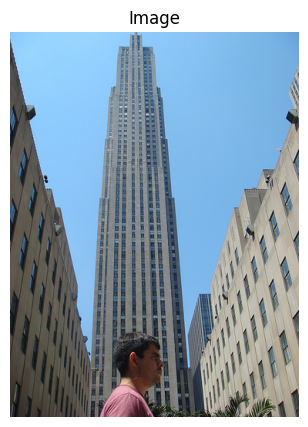

References:
  1. Binanın önünde poz veren kulaklık takmış adam.
  2. Bir adam uzun bir binanın önünde.
Prediction:
  ırmızışlü adam eşil lı   bir  çocu  imlerinerindeoynyorlar

Metrics:
  bleu1: 0.2857
  bleu2: 0.0000
  bleu3: 0.0000
  bleu4: 0.0000
  bleu: 0.0000
  meteor: 0.1244
  rougeL: 0.2485
  cider: 0.0000
  spice: 0.1053
  bertscore_f1: 0.8334


{'image_path': '/kaggle/input/tasviret/flickr8k/Images/1032460886_4a598ed535.jpg',
 'prediction': 'ırmızışlü adam eşil lı   bir  çocu  imlerinerindeoynyorlar',
 'references': ['Binanın önünde poz veren kulaklık takmış adam.',
  'Bir adam uzun bir binanın önünde.'],
 'metrics': {'bleu1': 0.2857142856326532,
  'bleu2': 6.900655591369778e-09,
  'bleu3': 2.119679665233836e-11,
  'bleu4': 1.2421889947162098e-12,
  'bleu': 1.2421889947162098e-12,
  'meteor': 0.12435233160621761,
  'rougeL': 0.2484725050916497,
  'cider': 0.0,
  'spice': 0.10526315789473685,
  'bertscore_f1': 0.8333990573883057},
 'mode': 'beam'}

In [ ]:
# Single-image qualitative check + metrics
from PIL import Image
import matplotlib.pyplot as plt
import evaluate

bertscore = evaluate.load('bertscore')

sample_path = sample_image_path  # assumed defined earlier
pred = model_mm.generate(image_paths=[sample_path], ban_sentinels=True)[0]
print('Generated:', pred)

# Show image
img = Image.open(sample_path).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()

# Compare against references if available
fname = os.path.basename(sample_path)
refs_for_img = [cap.strip() for f, cap in val_dataset.samples if f == fname and cap.strip()]
if refs_for_img:
    print('Reference captions:')
    for r in refs_for_img[:5]:
        print('-', r)
    # Turkish BERTScore
    bert = bertscore.compute(predictions=[pred], references=[refs_for_img[0]], lang='tr')
    print(f"BERTScore F1 (tr): {bert['f1'][0]:.4f}")
else:
    print('No references found for this image in validation set.')

In [ ]:
# === Example: Retrain from exported checkpoint on same or new dataset ===
# checkpoint_path = '/kaggle/input/your_export/clip_mt5_prefix_latest.pt'
# from torch.utils.data import DataLoader
# device = torch.device('cuda')
# model_re, cfg_re, hparams, epoch_loaded, step_loaded = load_model_for_retrain(
#     checkpoint_path,
#     device=device,
#     new_lr=5e-5,              # optionally override LR
#     new_clip_lr_scale=0.02,   # optionally override CLIP LR scale
#     freeze_clip=None,         # or True to freeze CLIP now
# )
# optimizer_re = build_optimizer_from_hparams(model_re, hparams)
# steps_per_epoch = len(train_loader)  # after you rebuild train_loader for (same or new) dataset
# scheduler_re = build_scheduler_from_hparams(optimizer_re, hparams, steps_per_epoch, total_epochs=5)
# # Proceed with standard training loop using model_re / optimizer_re / scheduler_re

In [ ]:
# # ==== Resume / Continue Training From Exported or Training Checkpoint (.pt) ====
# # Improvements:
# #  - Ensures 'checkpoints' directory exists before saving.
# #  - Handles tokenizer class mismatch notice by using AutoTokenizer in the pipeline.
# #  - Initializes best_val robustly (evaluates validation if inf).
# #  - Safe scheduler positioning.
# #  - Adds optional immediate validation before continuing to set baseline.

# RESUME_PATH = '/kaggle/input/15_epochs_tasviret/pytorch/default/1/clip_mt5_prefix_epoch_last.pt'  # change as needed
# EXTRA_EPOCHS = 5          # number of extra epochs to train
# RUN_INITIAL_VAL = True    # run a validation pass right after load to set best_val if missing
# SAVE_NAME = 'best_resumed.pt'

# import os, math, time, torch
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import LambdaLR

# os.makedirs('checkpoints', exist_ok=True)

# if not os.path.isfile(RESUME_PATH):
#     print(f"[RESUME] Path not found: {RESUME_PATH} -> Skip.")
# else:
#     print(f"[RESUME] Loading: {RESUME_PATH}")
#     bundle = torch.load(RESUME_PATH, map_location='cpu')

#     has_export_format = 'model_state' in bundle
#     has_train_ckpt_format = 'model' in bundle
#     if not (has_export_format or has_train_ckpt_format):
#         raise ValueError('Unrecognized checkpoint format.')

#     cfg_dict = bundle.get('cfg') or {}
#     class _Cfg: ...
#     cfg_resume = _Cfg()
#     for k, v in base_config.items():
#         setattr(cfg_resume, k, cfg_dict.get(k, v))

#     # Create pipeline (AutoTokenizer inside ensures consistency with checkpoint)
#     model_resume = CLIPmT5Pipeline(cfg_resume).to(device)

#     if has_export_format:
#         model_resume.load_state_dict(bundle['model_state'], strict=True)
#         loaded_epoch = bundle.get('epoch', -1)
#         global_step_loaded = bundle.get('global_step', None)
#         best_val_loaded = bundle.get('best_val', float('inf'))
#     else:
#         model_resume.load_state_dict(bundle['model'], strict=True)
#         loaded_epoch = bundle.get('epoch', -1)
#         global_step_loaded = bundle.get('global_step', None)
#         best_val_loaded = bundle.get('best_val', float('inf'))

#     print(f"[RESUME] Weights loaded (epoch={loaded_epoch}, best_val={best_val_loaded})")

#     main_params, clip_params = [], []
#     for n, p in model_resume.named_parameters():
#         if not p.requires_grad: continue
#         (clip_params if n.startswith('clip.') else main_params).append(p)
#     param_groups = []
#     if main_params: param_groups.append({'params': main_params, 'lr': cfg_resume.lr})
#     if clip_params: param_groups.append({'params': clip_params, 'lr': cfg_resume.lr * getattr(cfg_resume, 'clip_lr_scale', 0.05)})
#     optimizer_resume = AdamW(param_groups, weight_decay=cfg_resume.weight_decay)

#     steps_per_epoch = len(train_loader)
#     total_planned_epochs = loaded_epoch + 1 + EXTRA_EPOCHS
#     total_steps = steps_per_epoch * total_planned_epochs

#     def lr_lambda(step):
#         if cfg_resume.warmup_steps > 0 and step < cfg_resume.warmup_steps:
#             return float(step) / float(max(1, cfg_resume.warmup_steps))
#         progress = (step - cfg_resume.warmup_steps) / float(max(1, total_steps - cfg_resume.warmup_steps))
#         progress = min(max(progress, 0.0), 1.0)
#         return 0.5 * (1 + math.cos(math.pi * progress))

#     scheduler_resume = LambdaLR(optimizer_resume, lr_lambda=lr_lambda)

#     opt_key = 'optimizer_state' if has_export_format else 'optimizer'
#     sch_key = 'scheduler_state' if has_export_format else 'scheduler'
#     if opt_key in bundle:
#         try:
#             optimizer_resume.load_state_dict(bundle[opt_key])
#             print('[RESUME] Optimizer state restored.')
#         except Exception as e:
#             print('[WARN] Optimizer state load failed:', e)
#     if sch_key in bundle:
#         try:
#             scheduler_resume.load_state_dict(bundle[sch_key])
#             print('[RESUME] Scheduler state restored.')
#         except Exception as e:
#             print('[WARN] Scheduler state load failed:', e)

#     if scheduler_resume.last_epoch < 0 and loaded_epoch >= 0:
#         completed_steps = (loaded_epoch + 1) * steps_per_epoch
#         scheduler_resume.last_epoch = completed_steps
#         print(f"[RESUME] Scheduler last_epoch set to {scheduler_resume.last_epoch}")

#     amp_dtype_resume = None
#     if getattr(cfg_resume, 'use_amp', True):
#         if getattr(cfg_resume, 'use_bf16', False) and torch.cuda.is_bf16_supported():
#             amp_dtype_resume = torch.bfloat16
#         else:
#             amp_dtype_resume = torch.float16
#     scaler_resume = torch.amp.GradScaler('cuda', enabled=amp_dtype_resume is not None)

#     start_epoch = loaded_epoch + 1
#     end_epoch = loaded_epoch + EXTRA_EPOCHS

#     best_val = best_val_loaded

#     # Optional immediate validation to set best_val if it's inf or user wants baseline
#     if RUN_INITIAL_VAL and (best_val == float('inf') or best_val != best_val):  # inf or NaN
#         if val_loader:
#             model_resume.eval(); v=0.0
#             with torch.no_grad():
#                 for batch in val_loader:
#                     imgs, srcs, tgts = batch
#                     imgs = imgs.to(device, non_blocking=True)
#                     if amp_dtype_resume is not None:
#                         with torch.amp.autocast('cuda', dtype=amp_dtype_resume):
#                             out = model_resume(imgs, srcs, tgts)
#                     else:
#                         out = model_resume(imgs, srcs, tgts)
#                     v += out.loss.item()
#             best_val = v / max(1, len(val_loader))
#             print(f"[RESUME] Initial validation baseline best_val set to {best_val:.4f}")
#         else:
#             best_val = float('inf')

#     early_patience = getattr(cfg_resume, 'early_stop_patience', None)
#     min_delta = getattr(cfg_resume, 'early_stop_min_delta', 0.0)
#     _epochs_no_improve = 0

#     global_step_resume = global_step_loaded if global_step_loaded is not None else (start_epoch * steps_per_epoch)

#     print(f"[RESUME] Continue training for {EXTRA_EPOCHS} more epochs: {start_epoch} -> {end_epoch}")

#     for epoch in range(start_epoch, end_epoch + 1):
#         model_resume.train()
#         sum_loss = 0.0
#         t0 = time.time()
#         for step, batch in enumerate(train_loader, start=1):
#             imgs, srcs, tgts = batch
#             imgs = imgs.to(device, non_blocking=True)
#             optimizer_resume.zero_grad(set_to_none=True)
#             if amp_dtype_resume is not None:
#                 with torch.amp.autocast('cuda', dtype=amp_dtype_resume):
#                     out = model_resume(imgs, srcs, tgts)
#                     loss = out.loss
#                 scaler_resume.scale(loss).backward()
#                 if cfg_resume.grad_clip and cfg_resume.grad_clip > 0:
#                     scaler_resume.unscale_(optimizer_resume)
#                     torch.nn.utils.clip_grad_norm_(model_resume.parameters(), cfg_resume.grad_clip)
#                 scaler_resume.step(optimizer_resume)
#                 scaler_resume.update()
#             else:
#                 out = model_resume(imgs, srcs, tgts); loss = out.loss
#                 loss.backward()
#                 if cfg_resume.grad_clip and cfg_resume.grad_clip > 0:
#                     torch.nn.utils.clip_grad_norm_(model_resume.parameters(), cfg_resume.grad_clip)
#                 optimizer_resume.step()
#             scheduler_resume.step()
#             sum_loss += loss.item()
#             global_step_resume += 1
#         train_loss = sum_loss / max(1, len(train_loader))

#         val_loss = None
#         if val_loader:
#             model_resume.eval(); v = 0.0
#             with torch.no_grad():
#                 for batch in val_loader:
#                     imgs, srcs, tgts = batch
#                     imgs = imgs.to(device, non_blocking=True)
#                     if amp_dtype_resume is not None:
#                         with torch.amp.autocast('cuda', dtype=amp_dtype_resume):
#                             out = model_resume(imgs, srcs, tgts)
#                     else:
#                         out = model_resume(imgs, srcs, tgts)
#                     v += out.loss.item()
#             val_loss = v / max(1, len(val_loader))

#         dt = time.time() - t0
#         lr_cur = scheduler_resume.get_last_lr()[0]
#         if val_loss is not None:
#             print(f"[RESUME] Epoch {epoch} train={train_loss:.4f} val={val_loss:.4f} time={dt:.1f}s lr={lr_cur:.2e}")
#         else:
#             print(f"[RESUME] Epoch {epoch} train={train_loss:.4f} time={dt:.1f}s lr={lr_cur:.2e}")

#         metric = val_loss if val_loss is not None else train_loss
#         improved = metric < (best_val - min_delta)
#         if improved:
#             best_val = metric
#             _epochs_no_improve = 0
#             save_obj = {
#                 'model': model_resume.state_dict(),
#                 'cfg': {k: getattr(cfg_resume, k) for k in base_config.keys()},
#                 'epoch': epoch,
#                 'optimizer': optimizer_resume.state_dict(),
#                 'scheduler': scheduler_resume.state_dict(),
#                 'best_val': best_val,
#                 'global_step': global_step_resume,
#             }
#             torch.save(save_obj, os.path.join('checkpoints', SAVE_NAME))
#             print(f"   -> [RESUME] Saved {SAVE_NAME} (metric={best_val:.4f})")
#         else:
#             _epochs_no_improve += 1
#             if early_patience is not None and _epochs_no_improve >= early_patience:
#                 print(f"[Early Stop - Resume] No improvement for {early_patience} epochs.")
#                 break

#     print('[RESUME] Training extension finished. Final best_val=', best_val)
#     model_mm = model_resume